# kmeans using sklearn

In [84]:
import cv2 as cv
import os
import numpy as np
from sklearn.cluster import dbscan,mean_shift,KMeans

In [85]:
data = []
label = []
IMG_SIZE = 32
prefix_path = "./Train/"
sub_paths = [str(i) for i in range(43)]
for sub_path in sub_paths:
    path = prefix_path + sub_path +"/"
    number = 0
    for file in os.listdir(path):
        img = cv.imread(path + file)
        img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32')
        label.append(int(sub_path))
        data.append(img)
        number += 1
        if number > 200: break
data = np.array(data)

In [86]:
data_label = np.array([int(i) for i in label])

In [87]:
# Data Normalization
# Normalization
data = data/255.0
# k-means accept data with less than 3 dimensions
reshaped_data = data.reshape(len(data),-1)
reshaped_data.shape

(8643, 3072)

In [88]:
# Applying K-Means Clustering
kmeans = KMeans(n_clusters=43, random_state=0)
clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

(43, 3072)

In [89]:
kmeans.cluster_centers_ = kmeans.cluster_centers_*255

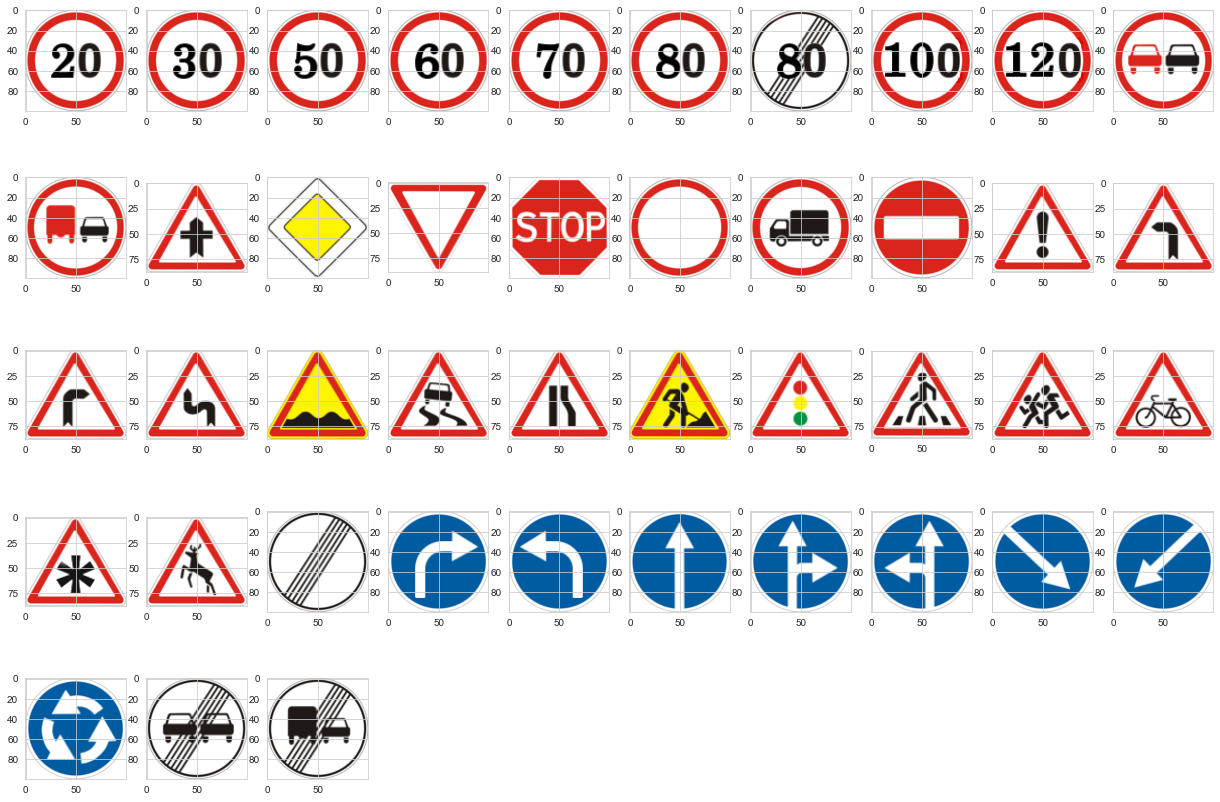

In [90]:
# This is how our centroids look like
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
dist_cols = 10
dist_rows = 7
bottom = 0.35
plt.figure(figsize=(3 * dist_cols, 3 * dist_rows))
for i in range(43):
    plt.subplots_adjust(bottom)
    plt.subplot(dist_rows, dist_cols, i+1)
    img = mpimg.imread("/Users/meijiaojiao/Downloads/image clustering/Meta/"+f"{i}"+".png")
    plt.imshow(img)
plt.savefig("Standard centers.png")

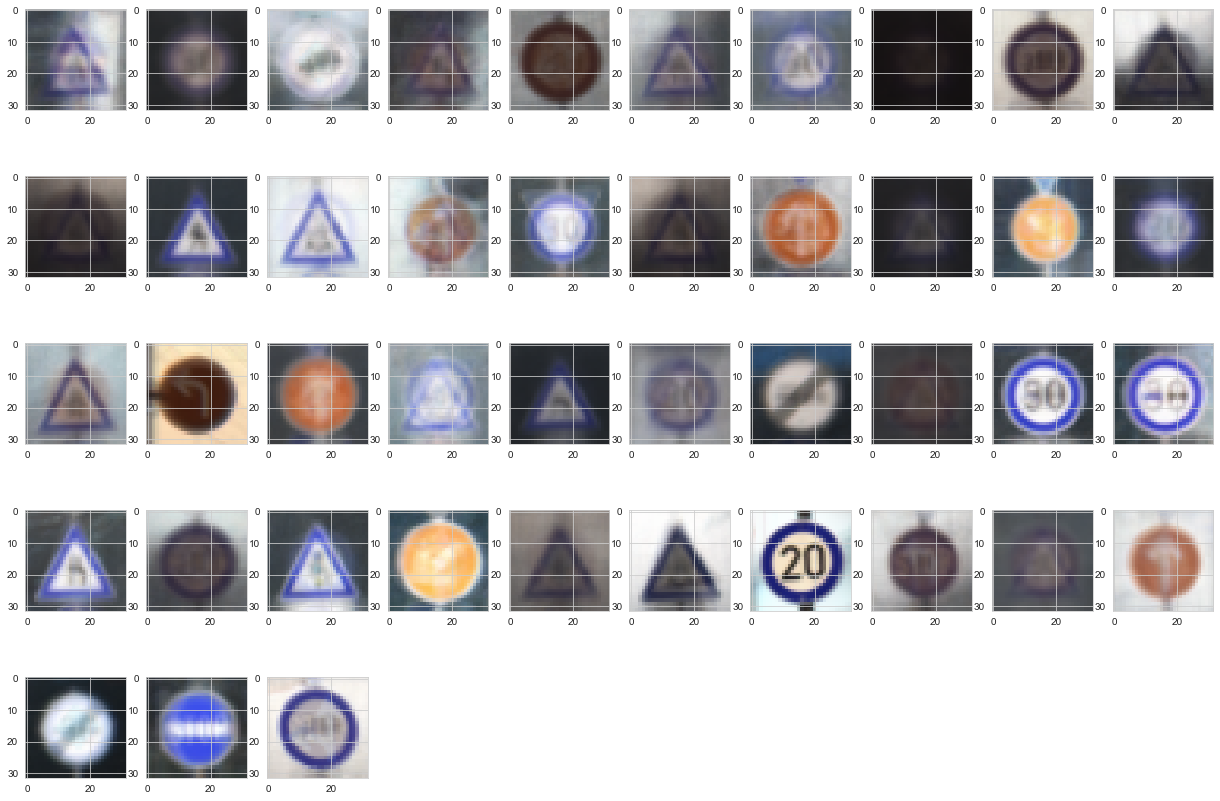

In [91]:
# This is how our centroids look like
import matplotlib.pyplot as plt
dist_cols = 10
dist_rows = 7
bottom = 0.35
plt.figure(figsize=(3 * dist_cols, 3 * dist_rows))
for i in range(43):
    plt.subplots_adjust(bottom)
    plt.subplot(dist_rows, dist_cols, i+1)
    plt.imshow(kmeans.cluster_centers_[i].astype(int).reshape(32,32,3))

# accuracy

In [93]:
# Since K-Means Does not know about our labels we have to change labels of k-means according to our usage
# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label

# Mapping predictions to original labels
def get_labels(clusters,reference_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

In [94]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

In [95]:
from sklearn.metrics import accuracy_score

# Accuracy Score for right predictions
print(accuracy_score(predicted_labels,data_label))

0.18083998611593197


# confusion matrix

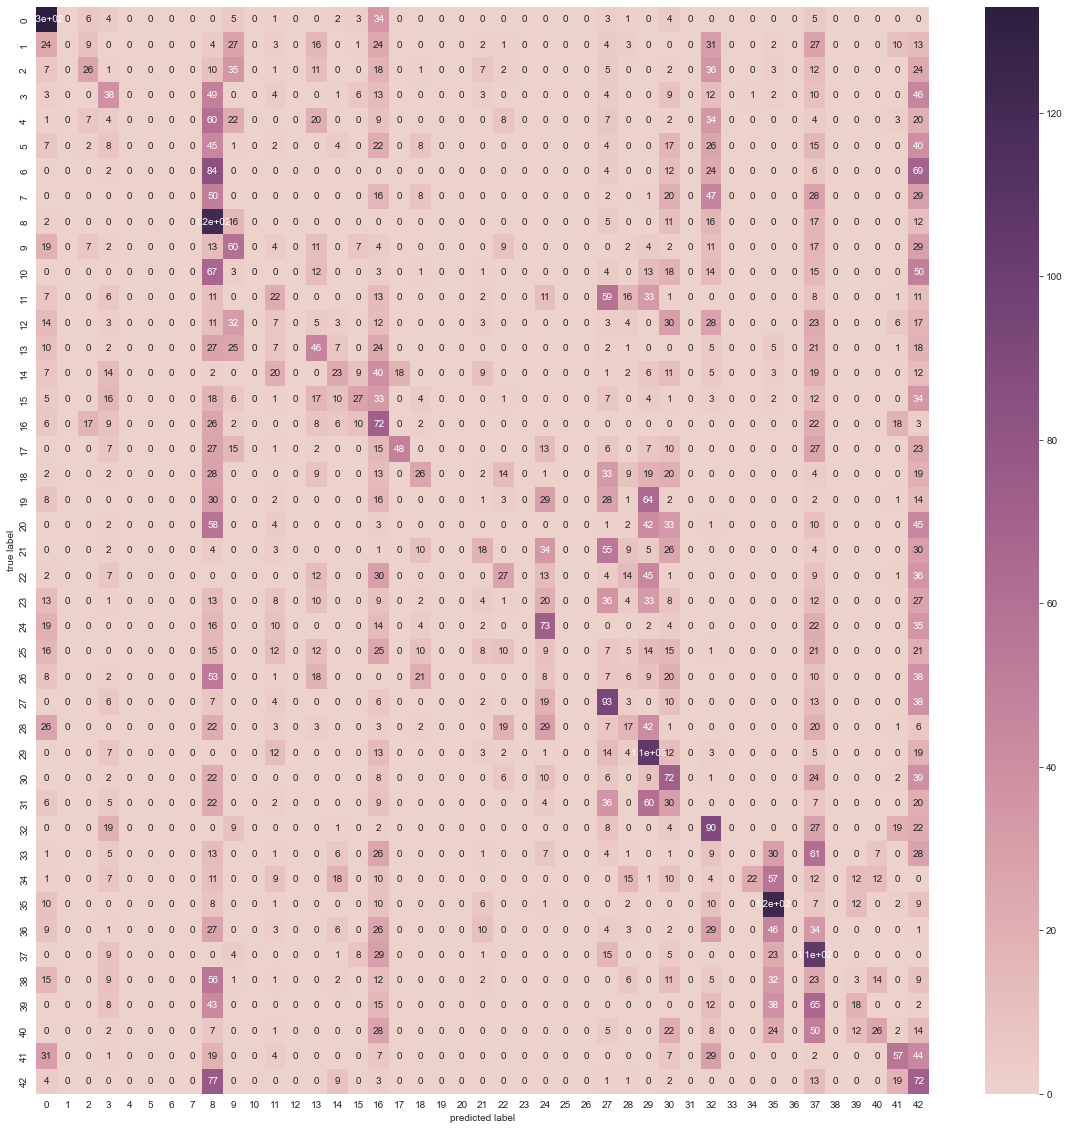

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(data_label,predicted_labels)
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(mat, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),ax=ax)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.show()

# elbow method

Accuracy for k = 5:  0.05958579197038066
Accuracy for k = 20:  0.11951868564155964
Accuracy for k = 43:  0.1874349184311003
Accuracy for k = 80:  0.2454009024644221
Accuracy for k = 256:  0.40934860580816845


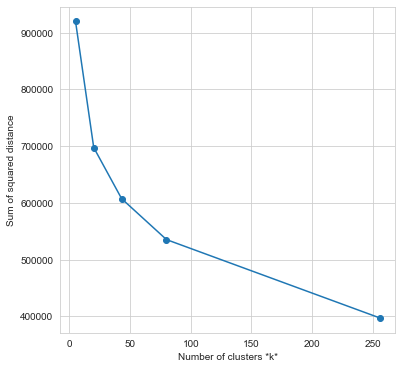

In [97]:
# elbow method
# squared distance
sse = []
list_k = [5,20,43,80,256]

for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)
    reference_labels = get_reference_dict(clusters,data_label)
    predicted_labels = get_labels(clusters,reference_labels)
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.savefig("./elbow method.png",dpi=300)

# resnet50 pretrained model

In [98]:
# Libraries
import keras
from keras.applications.resnet import preprocess_input
from keras.preprocessing import image

In [99]:
import keras.applications
model =  keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))

In [100]:
# Extract features from resnet50
from keras.utils import img_to_array
def extract_vector(data_holder):
    resnet_feature_list = []

    for im in data_holder:
        im = img_to_array(im)
#         print("dimensions of im: ", im.shape)
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
#         print("dimensions of img: ", img.shape)
        resnet_feature = model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
#         print("dimensions of resnet_feature_np: ", resnet_feature_np.shape)
        resnet_feature_list.append(resnet_feature_np.flatten())

    return np.array(resnet_feature_list)

In [101]:
# Extract vectors and apply kmeans
array = extract_vector(data)
kmeans = KMeans(n_clusters=43, random_state=0)
clusters = kmeans.fit_predict(array)

1/1 [==============================] - 0s 32ms/step


In [102]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)

1/1 [==============================] - 0s 34ms/step


# accuracy and confusion matrix

In [103]:
from sklearn.metrics import accuracy_score
print(accuracy_score(predicted_labels,data_label))

0.1833853985884531


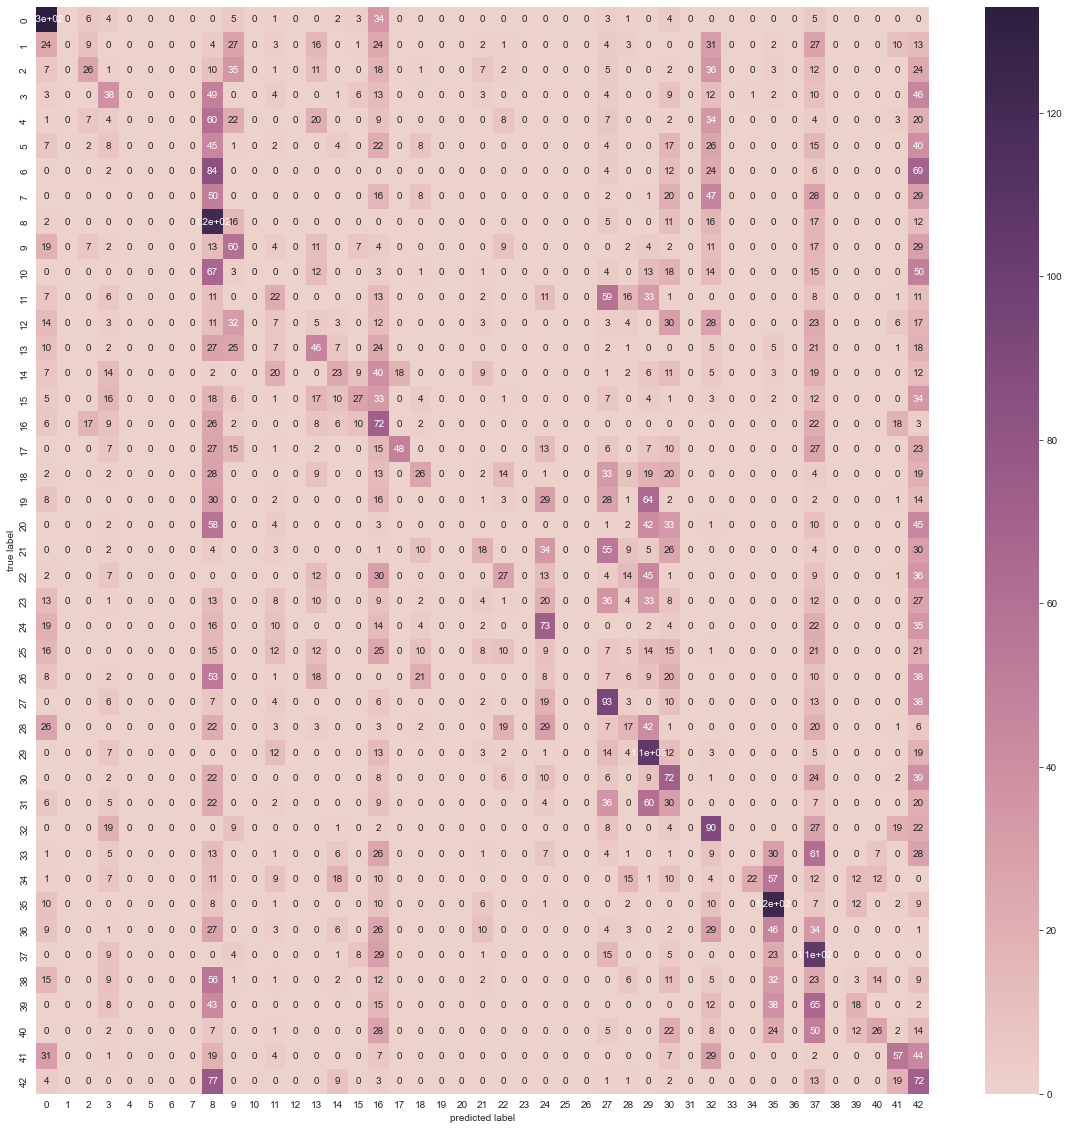

In [113]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(mat, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),ax=ax)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.savefig("confusion matirx.png",dpi=300)
plt.show()